In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
import torch.nn.functional as F  
import torchvision.models as models  # Import this line to access pre-trained models
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc


In [2]:
# # Paths to the files
# label_file_path = r"F:\Awais_data\Datasets\PartialSpoof\database_segment_labels\database\segment_labels\train_seglab_0.16.npy"
# csv_dir_path = r"C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1"
# csv_file_template = os.path.join(csv_dir_path, "train_segment_merged_part_{}.csv")

# # Load segment labels from .npy file
# segment_labels = np.load(label_file_path, allow_pickle=True).item()

# # Function to check the number of segment labels and features
# def diagnose_features_and_labels():
#     # Initialize dictionary to store diagnostics
#     diagnostics = {}
    
#     # Iterate through all 7 CSV files
#     for part in range(1, 20):
#         csv_file = csv_file_template.format(part)
        
#         # Load the CSV file
#         if not os.path.exists(csv_file):
#             print(f"CSV file not found: {csv_file}")
#             continue
#         print(f"Processing {csv_file}...")
#         df = pd.read_csv(csv_file)
        
#         # Iterate through each row in the CSV file
#         for _, row in df.iterrows():
#             file_id = row.iloc[0]  # File ID is in the first column
            
#             # Check if the file ID exists in the segment labels
#             if file_id in segment_labels:
#                 num_segment_labels = len(segment_labels[file_id])
#                 # Track the count of features for this file_id
#                 if file_id not in diagnostics:
#                     diagnostics[file_id] = {"labels_count": num_segment_labels, "features_count": 0}
#                 diagnostics[file_id]["features_count"] += 1

#     # Analyze mismatches and missing file IDs
#     mismatched_files = []
#     missing_file_ids = set(segment_labels.keys()) - set(diagnostics.keys())

#     for file_id, counts in diagnostics.items():
#         if counts["labels_count"] != counts["features_count"]:
#             mismatched_files.append(
#                 (file_id, counts["labels_count"], counts["features_count"])
#             )

#     # Print results
#     if mismatched_files:
#         print("Mismatched files (file_id, labels_count, features_count):")
#         for file_id, labels_count, features_count in mismatched_files:
#             print(f"File: {file_id} | Labels: {labels_count} | Features: {features_count}")
#     else:
#         print("No mismatches found.")

#     print(f"\nNumber of audio files in labels but not in features: {len(missing_file_ids)}")
#     if missing_file_ids:
#         print("Missing file IDs:")
#         print(", ".join(list(missing_file_ids)))

# # Run the diagnosis
# diagnose_features_and_labels()


In [3]:
# --------- 1. Merge CSV Files ---------
def merge_csv_files(directory, output_file, prefix="ps_merged_data"):
    # Identify files with the specified prefix and .csv extension
    csv_files = [os.path.join(directory, f) for f in os.listdir(directory) 
                 if f.startswith(prefix) and f.endswith('.csv')]
    
    # Load and concatenate all identified files
    df_list = []
    for file in csv_files:
        print(f"Reading file: {file}")  # Print the name of each file being read
        df_list.append(pd.read_csv(file))
    
    merged_df = pd.concat(df_list, ignore_index=True)
    
    # Save the merged dataframe to a single CSV file
    merged_df.to_csv(output_file, index=False)
    return merged_df

# Merge the files
csv_dir = r"D:\rrl_ssl\attention_emb\Partialspoof"
output_file = "merged_features.csv"
merged_data = merge_csv_files(csv_dir, output_file)

# Verify the result
print(f"Merged data shape: {merged_data.shape}")


Reading file: D:\rrl_ssl\attention_emb\Partialspoof\ps_merged_data.csv
Merged data shape: (533035, 1086)


In [4]:
# --------- 2. Preprocess Data ---------
def preprocess_data(df):
    # Extract features and labels
    file_names = df.iloc[:, 0]  # File names (not used for training)
    labels = df.iloc[:, -1].values  # Labels (1=real, 0=fake)
    features = df.iloc[:, 1:-1].values  # Features (1x1084)
    
    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features)
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(features_normalized, labels, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, features_normalized, labels

X_train, X_val, X_test, y_train, y_val, y_test, features, labels = preprocess_data(merged_data)



In [5]:
# --------- 3. Dataset and Dataloader ---------
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_classes=2, num_heads=8):
        super(AttentionModel, self).__init__()

        # Embedding layer to transform input features into the desired embedding dimension
        self.embedding = nn.Linear(input_dim, embedding_dim)

        # Multi-Head Self Attention Layer
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)

        # Feed Forward Network after Attention
        self.fc1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.fc2 = nn.Linear(embedding_dim * 2, num_classes)

        # Layer Normalization for stability
        self.layer_norm = nn.LayerNorm(embedding_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence length dimension
        attn_output, attn_weights = self.attention(x, x, x)
        x = self.layer_norm(attn_output + x)
        x = F.relu(self.fc1(x))
        embeddings = x.squeeze(1)  # Squeeze sequence length dimension
        logits = self.fc2(self.dropout(embeddings))
        return logits, embeddings, attn_weights

    # def forward(self, x):
    #     # Embedding input to match the attention input size
    #     x = self.embedding(x)  # [batch_size, seq_len, embedding_dim]

    #     # Adding a batch dimension for attention mechanism
    #     x = x.unsqueeze(1)  # Add a sequence length dimension [batch_size, 1, embedding_dim]

    #     # Attention Layer (self-attention)
    #     attn_output, attn_weights = self.attention(x, x, x)  # (batch_size, seq_len, embedding_dim), (batch_size, seq_len, seq_len)
        
    #     # Layer normalization after attention
    #     x = self.layer_norm(attn_output + x)

    #     # Feed Forward Network
    #     x = F.relu(self.fc1(x))
        
    #     embeddings = x  # This is the feature embedding 
        
    #     x = self.dropout(x)
    #     x = self.fc2(x)

    #     return embeddings, attn_weights  # Squeeze to get batch_size, num_classes output

input_dim = 1084
embedding_dim = 128
num_classes = 2
# Instantiate the model
model = AttentionModel(input_dim=input_dim, embedding_dim=embedding_dim, num_classes=num_classes).cuda()


In [7]:
# --------- NT-Xent Loss ---------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, z_i, z_j):
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        sim_matrix = torch.mm(z_i, z_j.t()) / self.temperature
        labels = torch.arange(z_i.size(0)).cuda()
        loss = nn.CrossEntropyLoss()(sim_matrix, labels)
        return loss


criterion = NTXentLoss()

In [8]:
 #--------- 6. Optimizer ---------
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [9]:
def calculate_eer(fpr, tpr):
    # Calculate EER (Equal Error Rate) from the FPR and TPR
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))  # Find where the FPR and TPR are closest
    eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
    return eer

def evaluate_model(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            # logits, _ = model(x)  # Forward pass
            logits, embeddings, _ = model(x)
            preds = torch.softmax(logits, dim=1)[:, 1]  # Assuming binary classification, take the positive class
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_preds)

    # Calculate Confusion Matrix
    cm = confusion_matrix(all_labels, (all_preds > 0.5).astype(int))

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    eer = calculate_eer(fpr, tpr)

    return auc_score, cm, eer

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train_contrastive_model(model, criterion, optimizer, train_loader, val_loader=None, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # Forward pass
            # logits, _ = model(x)
            logits, embeddings, _ = model(x)

            # Compute loss
            loss = nn.CrossEntropyLoss()(logits, y)  # Using cross-entropy for classification
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

        if val_loader:
            # Evaluate model on validation set after each epoch
            auc_score, cm, eer = evaluate_model(model, val_loader, device)
            print(f"Validation AUC: {auc_score:.4f}, EER: {eer:.4f}")

            # Confusion Matrix Plot
            # plot_confusion_matrix(cm, classes=["Fake", "Real"], title=f'Confusion Matrix Epoch {epoch+1}')
            # plt.savefig(f'confusion_matrix_epoch_{epoch+1}.png')
            # plt.close()

# Training the model with validation evaluation
train_contrastive_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)


Epoch 1/100, Loss: 0.3985
Validation AUC: 0.9195, EER: 0.1580
Epoch 2/100, Loss: 0.3428
Validation AUC: 0.9331, EER: 0.1411
Epoch 3/100, Loss: 0.3250
Validation AUC: 0.9385, EER: 0.1348
Epoch 4/100, Loss: 0.3132
Validation AUC: 0.9385, EER: 0.1341
Epoch 5/100, Loss: 0.3047
Validation AUC: 0.9432, EER: 0.1290
Epoch 6/100, Loss: 0.2968
Validation AUC: 0.9431, EER: 0.1288
Epoch 7/100, Loss: 0.2914
Validation AUC: 0.9432, EER: 0.1281
Epoch 8/100, Loss: 0.2867
Validation AUC: 0.9428, EER: 0.1294
Epoch 9/100, Loss: 0.2819
Validation AUC: 0.9473, EER: 0.1227
Epoch 10/100, Loss: 0.2777
Validation AUC: 0.9476, EER: 0.1231
Epoch 11/100, Loss: 0.2740
Validation AUC: 0.9462, EER: 0.1258
Epoch 12/100, Loss: 0.2710
Validation AUC: 0.9501, EER: 0.1184
Epoch 13/100, Loss: 0.2676
Validation AUC: 0.9508, EER: 0.1185
Epoch 14/100, Loss: 0.2650
Validation AUC: 0.9523, EER: 0.1156
Epoch 15/100, Loss: 0.2627
Validation AUC: 0.9530, EER: 0.1153
Epoch 16/100, Loss: 0.2594
Validation AUC: 0.9496, EER: 0.1205
E

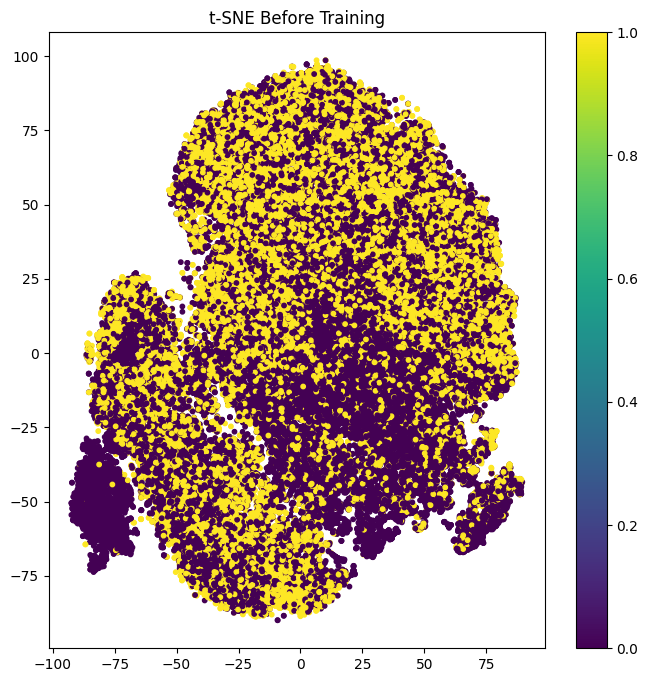

In [10]:
# --------- 8. t-SNE Visualization ---------
def plot_tsne(features, labels, title, save_path):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar()
    plt.title(title)
    plt.savefig(save_path)
    plt.show()

# t-SNE before training
plot_tsne(features[:80000], labels[:80000], "t-SNE Before Training", "tsne_before.png")

In [11]:
# t-SNE after training
model.eval()

AttentionModel(
  (embedding): Linear(in_features=1084, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

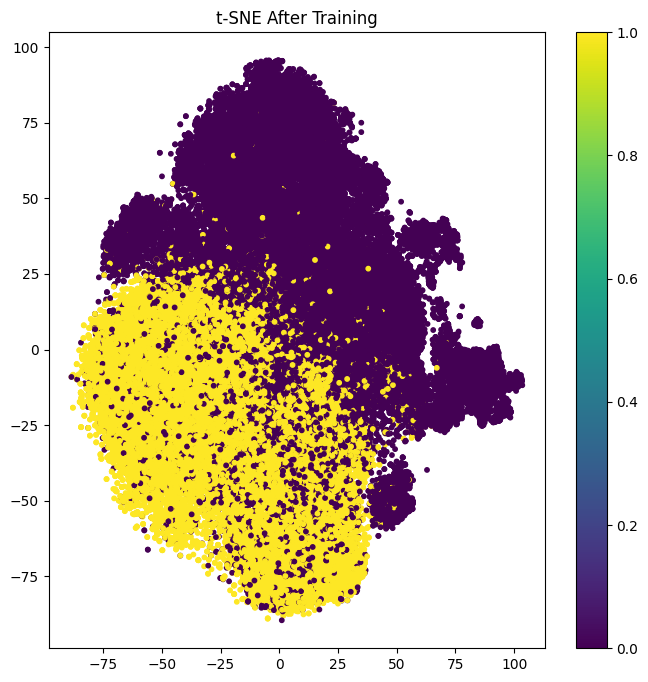

In [13]:
# Use torch.float32 dtype for input
with torch.no_grad():
    _,final_embeddings, _ = model(torch.tensor(features[:80000], dtype=torch.float32).cuda())  # Get only the embeddings (ignore attention_weights)
    final_embeddings = final_embeddings.cpu().numpy()  # Convert embeddings to CPU for visualization

plot_tsne(final_embeddings, labels[:80000], "t-SNE After Training", "tsne_after.png")



In [14]:
print(model)

AttentionModel(
  (embedding): Linear(in_features=1084, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [15]:
def model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params}")
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()}")

model_summary(model)


Total Parameters: 238722
embedding.weight: torch.Size([128, 1084])
embedding.bias: torch.Size([128])
attention.in_proj_weight: torch.Size([384, 128])
attention.in_proj_bias: torch.Size([384])
attention.out_proj.weight: torch.Size([128, 128])
attention.out_proj.bias: torch.Size([128])
fc1.weight: torch.Size([256, 128])
fc1.bias: torch.Size([256])
fc2.weight: torch.Size([2, 256])
fc2.bias: torch.Size([2])
layer_norm.weight: torch.Size([128])
layer_norm.bias: torch.Size([128])


In [16]:
pwd

'C:\\Notebooks'

In [17]:
# Saving the model
# Define local directory to save the model

save_directory = r"D:\rrl_ssl\attention_emb\Partialspoof"  # Replace with your preferred path
os.makedirs(save_directory, exist_ok=True)  # Create directory if it doesn't exist

# Define file paths for model and weights
model_path = os.path.join(save_directory, "specnet_partialspoof_model.pth")
weights_path = os.path.join(save_directory, "specnet_partialspoof_weights.pth")

# Save the trained SpecNet model and weights
torch.save(model.state_dict(), weights_path)  # Save weights
torch.save(model, model_path)                # Save the entire model

print(f"Trained model saved at: {model_path}")
print(f"Trained model weights saved at: {weights_path}")



Trained model saved at: D:\rrl_ssl\attention_emb\Partialspoof\specnet_partialspoof_model.pth
Trained model weights saved at: D:\rrl_ssl\attention_emb\Partialspoof\specnet_partialspoof_weights.pth


In [18]:
# Loading the model
# Define the paths to the saved model and weights
os.chdir(r'D:\rrl_ssl\attention_emb\Partialspoof')

model_path = ".\specnet_partialspoof_model.pth"  # Replace with your saved model path
weights_path = ".\specnet_partialspoof_weights.pth"  # Replace with your weights path

def load_model_from_local(model_path, weights_path, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    
    # Load the full model
    loaded_model = torch.load(model_path, map_location=device)
    loaded_model.eval()  # Set the model to evaluation mode
    print("Model and weights successfully loaded from local directory.")
    return loaded_model

# Load the model
device = "cuda"  # Specify the device to load the model
loaded_model = load_model_from_local(model_path, weights_path, device)


Model and weights successfully loaded from local directory.


C:\Users\mawais\AppData\Local\Temp\ipykernel_40412\2870312939.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path, map_location=device)

In [26]:
import torch
import pandas as pd
import numpy as np

# Load your trained model
# model = torch.load('C:\Notebooks\rrl_source\Spectnet_model_Halftruth_embedding')
model.eval()  # Set the model to evaluation mode for consistent embeddings

# Read input CSV containing Fileid, raw features, and label
input_csv = r'C:\Notebooks\rrl_source\Spectnet_model_Partialspoof_embedding\merged_data.csv'  # Replace with the actual file path
df = pd.read_csv(input_csv)
print(df.columns)

# Rename the first and last columns appropriately
df.rename(columns={df.columns[0]: 'FileID', df.columns[-1]: 'Label'}, inplace=True)

# Verify the renaming
print(df.head())
# Assuming the first column is 'Fileid', the last column is 'Label', and the intermediate columns are raw features
fileids = df['FileID'].values
labels = df['Label'].values
raw_features = df.drop(['FileID', 'Label'], axis=1).values

# Convert raw features to a tensor
raw_features_tensor = torch.tensor(raw_features, dtype=torch.float32).cuda()

# Lists to store embeddings, file IDs, and labels
all_embeddings = []
all_fileids = []
all_labels = []

# Extract embeddings
with torch.no_grad():  # No gradient tracking during extraction
    for i in range(len(raw_features)):
        feature = raw_features_tensor[i:i+1]  # Extract single feature (1, feature_size)
        label = labels[i]  # The corresponding label for the feature
        fileid = fileids[i]  # The corresponding file ID

        # Pass through the model to get the embeddings
        x = model.embedding(feature)  # Embedding layer
        x = x.unsqueeze(1)  # Add sequence length dimension
        attn_output, _ = model.attention(x, x, x)  # Attention layer
        embeddings = model.layer_norm(attn_output + x)  # Normalized attentive embeddings

        # Convert embeddings to CPU and numpy for storage
        embeddings_cpu = embeddings.cpu().numpy().flatten()  # Flatten to 1D if necessary

        # Append fileid, label, and embeddings to respective lists
        all_fileids.append(fileid)
        all_labels.append(label)
        all_embeddings.append(embeddings_cpu)

# Convert lists to numpy arrays
all_embeddings = np.array(all_embeddings)
all_labels = np.array(all_labels)

# Create a new DataFrame to save the extracted embeddings and labels
columns = ['FileID'] + [f'Feature_{i+1}' for i in range(all_embeddings.shape[1])] + ['Label']
output_df = pd.DataFrame(np.column_stack([all_fileids, all_embeddings, all_labels]), columns=columns)

# Save the result to a new CSV file
output_csv = 'Partialspoof_attentive_embeddings.csv'  # Replace with desired output file path
output_df.to_csv(output_csv, index=False)

print(f"Extracted attentive embeddings saved to {output_csv}")


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083', '1084',
       '1085'],
      dtype='object', length=1086)
          FileID           1           2          3          4          5  \
0  CON_T_0000000 -659.133983   86.243724   4.973924   4.425039   4.377807   
1  CON_T_0000000 -760.639504   91.021404  33.370544  22.597787  10.416623   
2  CON_T_0000000 -792.766713   75.536289  39.630041  23.278883  10.476208   
3  CON_T_0000000 -498.649228  -14.332047   5.176422  32.277727   1.299799   
4  CON_T_0000000 -362.035089  125.278027 -34.775617  51.507827  10.867787   

           6          7          8          9  ...      1076      1077  \
0   7.391501 -11.917141 -14.691260 -19.621890  ... -0.089203  0.102760   
1   9.139064   0.017621  -3.285333 -10.108316  ... -0.089527  0.102146   
2  10.901251   8.224448  10.263298  10.520130  ... -0.089542  0.103426   
3  14.007900   1.442406  -2.285363   7.6038

In [ ]:
final_embeddings.shape